In [1]:
import random
import time
import math
import copy
import numpy as np
import pandas as pd
from typing import List, Tuple
import scipy
import matplotlib.pyplot as plt

# Grey Wolf Optimizer

1. Initialize the population

In [2]:
#NIND is the number of wolves, n is the number of cities, m is the number of travelers, start is the start city
def init(NIND,n,m,start):
    len = n+m-1 #The length of a wolf
    population = []
    for i in range(NIND):
        population.append(individual(n,m,start))
    return population

#generate wolf invividual according to the number of cities and travelers. Each wolf has two parts, 
#the first part is the city serial numbers that each traveler visits, the second part is the number of cities that each traveler visits
def individual(n,m,start):
    #The first part of the wolf
    part1 = [i for i in range(n)]
    part1.remove(start)
    random.shuffle(part1)
    #The second part of the wolf
    part2 = [0] * m

    if m == 1:
        part2 = [n-1]
    else: 
        for i in range(m):# m travelers in total
            if i == 0:
                right = n-1 - (m-1)
                part2[i] = random.randint(1,right)
            elif i == m-1:
                part2[i] = n-1 - sum(part2[:i])
            else:
                right = n-1 -(m-i)- sum(part2[:i])
                part2[i] = random.randint(1,right)
    individual = part1 + part2
    return individual

2. Ojbective function

In [3]:
def objective(population,n,m,start,distance):
    NIND = len(population)
    obj = [0] * NIND
    for i in range(NIND):
        individual = population[i]
        RP= decode(individual,n,m,start)
        obj[i] = travel_distance(RP,distance)[2]
    return obj

#decode the individual to get the route of each traveler
def decode(individual,n,m,start):
    RP = []
    part1 = individual[:n-1]
    part2 = individual[n-1:]
    for i in range(m):
        if i == 0 :
            left = 0
            right = part2[i]
            route = [start]+ part1[left:right] + [start]
        else:
            left = sum(part2[:i])
            right = sum(part2[:i+1])
            route = [start] + part1[left:right] + [start]
        RP.append(route)
    return RP

#calculate the total distance of each traveler and the sum of all travelers' distance
def travel_distance(RP,distance):
    m = len(RP)
    TD = [0] * m
    for i in range(m):
        route = RP[i]
        TD[i] = route_length(route,distance)
    sumTD = sum(TD)
    maxTD = max(TD)
    return TD, sumTD, maxTD

#The length of a route
def route_length(route,distance):
    route_length = 0
    for i in range(len(route)-1):
        route_length += distance[route[i]][route[i+1]]
    return route_length

3. Wolf Indiviual position Updating:  Cross

In [4]:
#Update wolf postion by crossing their routes
def cross(x,y,n,m,start,distance):
    individual1 = x.copy()
    individual2 = y.copy()
    route1 = individual1[:n-1]
    route2 = individual2[:n-1]
    l = n-1
    #s and e are the starting and ending points of the crossover
    r1, r2 = random.sample(range(l-1),2)
    s = min(r1,r2)
    e = max(r1,r2) + 1
    X_segment = route1[s:e]
    Y_segment = route2[s:e]
    X = X_segment + [item for item in route2 if item not in X_segment]
    Y = Y_segment + [item for item in route1 if item not in Y_segment]

    individual1 = X + individual1[l:]
    individual2 = Y + individual2[l:]
    individuals = [x,y,individual1,individual2]
    TD = []
    for i in range(4):
        TD.append(travel_distance(decode(individuals[i],n,m,start),distance)[2])
    best = individuals[np.argsort(TD).tolist()[0]]
    return best

4. Wolf Individual Updating: Local Search

In [5]:
#Local search operator, consists of two parts: remove and repair
def Localsearch(individual,n,m,k,start,distance):
    RP = decode(individual,n,m,start)
    TD_initial = travel_distance(RP,distance)[2]
    #1. Destroy operator
    removed,remained = remove(RP,n,m,k,start,distance)#remove k cities from RP
    #2. Repair operator
    repaired_RP = repair(removed,remained,distance)
    #3. Update if individual is better
    TD_after = travel_distance(repaired_RP,distance)[2]
    if TD_after < TD_initial:
        individual = update(repaired_RP,start)
    obj = min(TD_initial,TD_after)
    return individual, obj
'''
Destroy Operator
'''
def remove(RP,n,m,k,start,distance): #remove k routes from Route i
    avg = round((n-1)/m)
    removed = []
    T = [] #destroyed routes index Set
    remained = []
    seed = random.choice(range(n-1)) #randomly select a city as the seed city
    ordered = order(start,seed,distance)#cities that are adjacent to the seed city are ordered from closest to farthest
    for i in range(len(ordered)):
        if len(T) < k:
            route, route_index = tour(ordered[i],RP) #the route and its index that the visited city belongs to
            if route_index not in T:
                Lmax = min(len(route)-2,avg) # minus 2 because the start city and the end city can not be removed
                if Lmax >= 1:
                    l = random.randint(1,Lmax)
                    removed_route = remove_cities(l,route,ordered[i],start)# remove l adjacent cities from route 
                    removed.append(removed_route)                    
                    T.append(route_index)
    remained = dealRemove(removed,RP) # remove cities in removed from RP
    return removed, remained

#sort the cities that are adjacent to the seed city from closest to farthest
def order(start,seed,distance):
    dist = copy.deepcopy(distance)
    dist = dist[seed]
    dist[start] = math.inf #The start city can not be removed so the distance to start city is set to infinity
    ordered = np.argsort(dist).tolist()
    return ordered

#return the route and its index that the visited city belongs to
def tour(visit,RP):
    m = len(RP)
    for i in range(m):
        route_i = RP[i]
        if visit in route_i:
            return route_i, i

# return the route after removing l adjacent cities from route
def remove_cities(l,route,visit,start):# l: the number of cities to be removed
    route_copy = route.copy()
    route_copy = [x for x in route_copy if x != start]
    cities_num = len(route_copy)
    #if remove all cities in the route, return the route
    if cities_num == l:
        removed = route_copy
        return removed
    index = route_copy.index(visit) # the index of the visited city in the route
    left = index # city numbers on the left side of the visited city
    right = cities_num - index - 1 # city numbers on the right side of the visited city
    #remove l adjacent cities including 'visit' from route
    if left == 0:
        nL = 0
    else:
        nL = random.randint(1,min(left,l)) # remove nL cities on the left side of the visited city
    nR = l - nL # remove nR cities on the right side of the visited city
    if nR > right:
        nR = right
        nL = l - nR
    removed = route_copy[index-nL:index+nR]
    return removed

#remove cities in removed from RP
def dealRemove(removed,RP):
    remained = []
    for i in range(len(RP)): # for all routes
        route = RP[i]
        for j in range(len(removed)):
            try:
                _ = route.index(removed[j][0]) # if the removed city is in the current route
                route_i = [x for x in route if x not in removed[j]]
                remained.append(route_i)
                break
            except:
                continue
    return remained

'''
Repair Operator
'''
#Insert every removed city to certain route respectively based on regret matching
def repair(removed,remained,distance): #return the repaired route, repair operator is regret matching
    removed = flat(removed) # flatten the removed cities to one dimension
    repaired = remained
    #if repaired route is empty, insert random removed city to the route
    for i in range(len(repaired)):
        if repaired[i] == []:
            repaired[i].append(removed[0])
            removed.remove(removed[0])
    while removed:
        maxTD = travel_distance(repaired,distance)[2] # the maximum distance of current routes
        regret_values = [] # the regret value of city i
        inserted_routeIndexes = [] # the route that the removed city is added to
        inserted_position = [] # the inserting position of the removed city in the route
        routes = []
        for i in range(len(removed)): # for all the removed cities
            visit = removed[i]
            regret_value, route_m, min_insert_index, route = insertRoute(visit,repaired,distance,maxTD)
            regret_values.append(regret_value)
            inserted_routeIndexes.append(route_m)
            inserted_position.append(min_insert_index)
            routes.append(route)
        max_regret_index = np.argmax(regret_values).tolist()# the removed city with the maximum regret value    
        inserted_routeIndex = inserted_routeIndexes[max_regret_index] # the route that the removed city is added to
        repaired[inserted_routeIndex] = routes[max_regret_index] # update the route that the removed city is added to
        removed.remove(removed[max_regret_index]) # remove the added city from the removed list
    return repaired

def insertRoute(visit,RP,distance,maxTD): #Calculate the smallest cost of adding the removed city to the route
    regret_values = [] # store the regret value of inserting the removed city to each route
    min_cost_position = []# store the inserting position of the removed city in each route
    routes = []
    for m in range(len(RP)):
        route = RP[m]
        start = route[0]
        route_copy = route.copy()
        route_copy = [x for x in route_copy if x != start]
        length = len(route_copy)
        inserted_route = []
        costs = []
        for i in range(length+1):# insert the removed city to route m
            if i == length:
                rc = [start] + route_copy + [visit] + [start]
            elif i == 0:
                rc = [start] + [visit] + route_copy + [start]
            else:
                rc = [start] + route_copy[:i] + [visit] + route_copy[i:] + [start]
            inserted_route.append(rc)
            cost = route_length(rc,distance) - maxTD # the cost of adding the removed city to the route
            costs.append(cost)
        sorted_cost, sorted_cost_index = sorted(costs), np.argsort(costs).tolist()

        if len(sorted_cost) > 1:
            regret_value_m = sorted_cost[1] - sorted_cost[0] # the regret value of inserting the removed city to route m
        else:
            regret_value_m = sorted_cost[0]

        min_cost_index_m = sorted_cost_index[0] # the minimum cost index of inserting the removed city to route m
        regret_values.append(regret_value_m)
        min_cost_position.append(min_cost_index_m)
        routes.append(inserted_route[min_cost_index_m])
    # sort the regret values of inserting to each route from smallest to largest
    regret_values, route_index = sorted(regret_values), np.argsort(regret_values).tolist()
    regret_value, route_m = regret_values[0], route_index[0]# the smallest regret value and the route index
    min_insert_index = min_cost_position[route_m] # the inserting position of the removed city in the route
    route = routes[route_m]
    return regret_value, route_m, min_insert_index, route

def flat(l):
    result = []
    for item in l:
        if isinstance(item,list):
            for subitem in item:
                result.append(subitem)
        else:
            result.append(item)
    return result

#updat wolf individual giving Route Plan
def update(RP,start):
    m = len(RP)
    routes = []
    city_nums = []
    for i in range(m):
        route = RP[i]
        route = [x for x in route if x != start]
        city_nums.append(len(route))
        routes = routes + route
    individual = routes + city_nums
    return individual

5. Plot MTSP

In [6]:
def draw(RP,cities,start):
    start_vertex = cities[start]
    m = len(RP)
    plt.plot(start_vertex[0],start_vertex[1],'rs',markersize=10)
    for i in range(m):
        route = RP[i]
        route_vertex = [start_vertex] + [cities[x] for x in route] + [start_vertex]
        x,y = zip(*route_vertex)
        plt.plot(x,y,'o-')
    plt.show()

6. Main Function

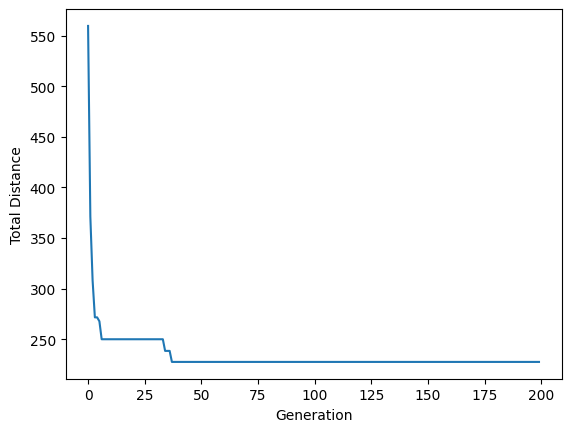

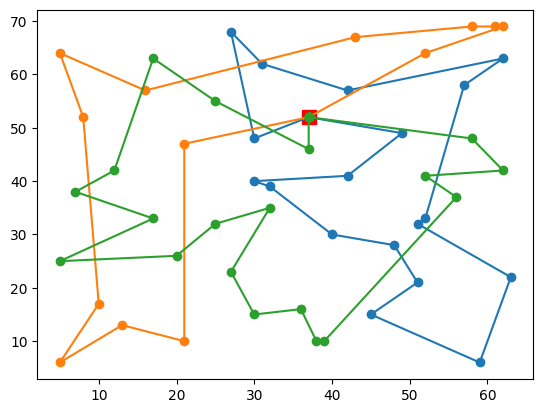

In [7]:
#According to objective function defined above, the optimization goal is to minimize the longest route among
#all the travelers.
'''
1. Initialize the population 
'''
# n : city numbers
# m: traveler numbers
# start : start city index
# distance : distance matrix for all the cities
# NIND : the number of the wolf population
# k : route to be destroyed in Local Search operator, must be less than or equal to  tralver numbers
data = pd.read_csv('example_data/MTSP.csv')
cities = tuple(zip(data['x'], data['y']))
n = len(cities)
m = 3
start = 0
distance = scipy.spatial.distance.cdist(cities,cities, 'euclidean').tolist() #distance matrix
NIND = 50
MAXGEN = 200
k = m
population_init = init(NIND,n,m,start)
population = copy.deepcopy(population_init)
init_obj = objective(population,n,m,start,distance)

best_alpha = []
best_obj = []
#Generate alpha, beta and delta wolves
alpha = population[0]
alpha_obj = init_obj[0]
beta = population[1]
beta_obj = init_obj[1]
delta = population[2]
delta_obj = init_obj[2]
'''
2.Evolution
'''
gen = 0
while gen < MAXGEN:
    obj = objective(population,n,m,start,distance)
    #Update wolf individuals using cross operator
    cross_invididual = random.sample(range(NIND),int(random.random()*NIND))#randomly select some wolves to cross

    for i in cross_invididual:#do not cross the alpha wolf
        r = random.random()
        individual = population[i]
        if r <= 1/3:
            new_individual = cross(individual,alpha,n,m,start,distance)
        elif r <= 2/3:
            new_individual = cross(individual,beta,n,m,start,distance)
        else:
            new_individual = cross(individual,delta,n,m,start,distance)
        #Update the wolf if the new wolf is better
        population[i] = new_individual

    #Local search operator 
    alpha, alpha_obj = Localsearch(alpha,n,m,k,start,distance)
    beta, beta_obj = Localsearch(beta,n,m,k,start,distance)
    delta, delta_obj = Localsearch(delta,n,m,k,start,distance)
    #Update alpha, beta and delta wolves
    sorted_obj, sorted_index = sorted(obj), np.argsort(obj).tolist()
    population[sorted_index[0]],sorted_obj[0] = alpha,alpha_obj
    population[sorted_index[1]],sorted_obj[1] = beta,beta_obj
    population[sorted_index[2]],sorted_obj[2] = delta,delta_obj
    #The best wolf in the current generation
    best_alpha.append(alpha)
    best_obj.append(alpha_obj)
    #print('Generation: ',gen,'Best objective:',alpha_obj)
    gen += 1

#plot best obj in each generation
plt.plot(best_obj)
plt.xlabel('Generation')
plt.ylabel('Total Distance')
plt.show()
#plot the final route
best_RP = decode(alpha,n,m,start)
travel_distance(best_RP,distance)
draw(best_RP,cities,start)